# Visualise and summaries occlusion maps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import glob
import cv2
from tqdm import tqdm

import utils 
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/occlusion-image-segmentation/src/utils.py'>

In [14]:
#aggregate random plots
maps_random_paths = glob.glob('../maps_random_1/*.npy')

for path in maps_random_paths:
    try:
        random_1 = np.load(path)
        random_2 = np.load(path.replace('maps_random_1', 'maps_random_2'))
        random_3 = np.load(path.replace('maps_random_1', 'maps_random_3'))
        random_mean =np.mean([random_1, random_2, random_3], axis=0)
        #random_mean =np.mean([random_1, random_2], axis=0)

        save_path = path.replace('maps_random_1', 'maps_random')

        np.save(save_path, random_mean)
    except:
        print(path)
        continue

In [15]:
# Load paths
test_paths = glob.glob('../../data/LICS/test/*')
print(len(test_paths))

map_zero_paths = glob.glob('../maps/*.npy')
maps_mean_paths = glob.glob('../maps_mean/*.npy')

maps_random_paths = glob.glob('../maps_random/*.npy')

print(len(map_zero_paths), len(maps_mean_paths), len(maps_random_paths))
print(map_zero_paths[0])

100
21810 5425 5425
../maps/LC08_L2SP_208024_20220812_20220824_02_T1_pixel_coastline_46_137_8_4.npy


## Calculate weighted context

In [16]:
# Create maps_df
rows = []
map_paths = [map_zero_paths, maps_mean_paths, maps_random_paths]
occlusion_types = ['zero', 'mean', 'random']
for paths, occlusion_type in zip(map_paths, occlusion_types):
    for map_path in tqdm(paths):

        map_name = map_path.split('/')[-1].split('.')[0]

        map_name_split = map_name.split('_')

        image_name = '_'.join(map_name_split[0:7])

        map_type = map_name_split[7]
        pixel_class = map_name_split[8]

        if map_type == 'pixel':
            x = int(map_name_split[9])
            y = int(map_name_split[10])
        else:
            x = 0
            y = 0
        
        patch_size = int(map_name_split[-2])
        stride = int(map_name_split[-1])

        heatmap = np.load(map_path)
        weighted_context, normalized_weighted_context = utils.calc_weighted_context((int(x), int(y)), heatmap)

        rows.append([image_name,occlusion_type, map_type, pixel_class, x, y, patch_size, stride,
                    weighted_context, normalized_weighted_context, map_path])

maps_df = pd.DataFrame(rows, columns=['image_name','occlusion_type', 'map_type', 'pixel_class', 'x', 'y', 'patch_size', 'stride',
                                      'weighted_context', 'normalized_weighted_context', 'map_path'])
maps_df.sort_values(by=['image_name','occlusion_type', 'map_type', 'pixel_class', 'patch_size', 'stride'], inplace=True)
maps_df.head()

100%|██████████| 5425/5425 [00:04<00:00, 1239.45it/s]


,image_name,occlusion_type,map_type,pixel_class,x,y,patch_size,stride,weighted_context,normalized_weighted_context,map_path
24473,LC08_L2SP_205023_20170505_20200904_02_T1,mean,mask,coastline,0,0,8,1,6.202580e+05,0.048475,../maps_mean/LC08_L2SP_205023_20170505_2020090...
25076,LC08_L2SP_205023_20170505_20200904_02_T1,mean,mask,fn,0,0,8,1,2.024456e+05,0.015822,../maps_mean/LC08_L2SP_205023_20170505_2020090...
26705,LC08_L2SP_205023_20170505_20200904_02_T1,mean,mask,fp,0,0,8,1,5.530031e+05,0.043219,../maps_mean/LC08_L2SP_205023_20170505_2020090...
23070,LC08_L2SP_205023_20170505_20200904_02_T1,mean,mask,land,0,0,8,1,5.137492e+05,0.040151,../maps_mean/LC08_L2SP_205023_20170505_2020090...
23417,LC08_L2SP_205023_20170505_20200904_02_T1,mean,mask,water,0,0,8,1,2.224986e+06,0.173889,../maps_mean/LC08_L2SP_205023_20170505_2020090...


In [17]:
maps_df.to_csv('../maps_df.csv', index=False)

In [18]:
maps_df = pd.read_csv('../maps_df.csv')
# Sense check we have the correct number of maps
print(maps_df['image_name'].value_counts())

print(maps_df['stride'].value_counts())

print(maps_df['pixel_class'].value_counts())

image_name
LT05_L2SP_207024_19871024_20201014_02_T1    440
LC08_L2SP_205023_20170505_20200904_02_T1    330
LT05_L2SP_206023_19941004_20200913_02_T1    330
LT05_L2SP_207022_19890506_20200917_02_T1    330
LT05_L2SP_207022_19881010_20200917_02_T1    330
                                           ... 
LC08_L2SP_208023_20220305_20220314_02_T1    288
LC08_L2SP_205024_20210719_20210729_02_T1    288
LT05_L2SP_205024_19930401_20200914_02_T1    282
LT05_L2SP_207023_19900423_20200916_02_T1    276
LC08_L2SP_207022_20161124_20200905_02_T1    270
Name: count, Length: 100, dtype: int64
stride
1     16385
4      5425
8      5425
16     5425
Name: count, dtype: int64
pixel_class
coastline    6622
land         6622
water        6622
fn           6556
fp           6238
Name: count, dtype: int64


## Example occlusion map

In [19]:
def get_data_from_row(row, normalized=False,contrast=0.2):

    """Get data from a row in the maps_df"""

    row = row.copy()

    x = row['x'].values[0]
    y = row['y'].values[0]
    pixel = (x,y)

  
    if normalized:
        weighted_context = row['normalized_weighted_context'].values[0]

    else:
        weighted_context = row['weighted_context'].values[0]
        weighted_context = np.round(weighted_context)
        weighted_context = weighted_context.astype(int)
    

    map_path = row['map_path'].values[0]
    heatmap = np.load(map_path)

    # Get image data
    name = row['image_name'].values[0]  
    path = f'../../data/LICS/test/{name}.npy'

    # Load data
    img = np.load(path)

    rgb = utils.get_rgb(img,contrast=contrast)
    mask = img[:,:,-2]
    edge = img[:,:,-1]

    return pixel,weighted_context,heatmap,rgb,mask,edge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(np.int64(177), np.int64(79))
mean


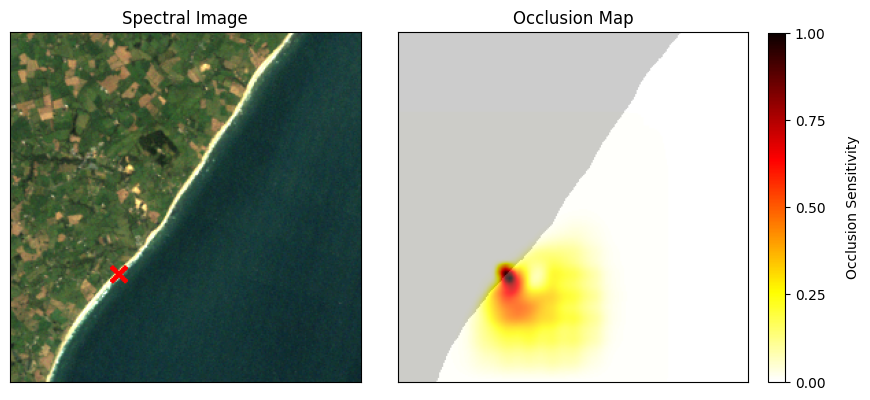

In [111]:
# Plot_example
map_type = "pixel"
#pixel_class = "land"
importlib.reload(utils)
patch_size = 8
stride = 1

maps_df_example = maps_df[(maps_df['map_type'] == map_type)  & (maps_df['patch_size'] == patch_size) & (maps_df['stride'] == stride) & (maps_df['normalized_weighted_context'] >=0.001)]

maps_example = maps_df_example.sample(1)

pixel,weighted_context,heatmap,rgb,mask,edge = get_data_from_row(maps_example,normalized=True,contrast=0.2)

print(pixel)
print(maps_example['occlusion_type'].values[0])
overlay = utils.occlusion_visualisation(mask, heatmap, alpha=0.8)
utils.plot_occlusion_map(rgb, overlay,pixel)

#utils.save_fig("example_occlusion_map")

## Compare weighted context to occlusion values

In [20]:
def get_example(pixel_class,occlusion_type='zero', map_type= "pixel", patch_size=8, stride=1, normalized=False, contrast=0.2):
    
    examples = maps_df[(maps_df['pixel_class'] == pixel_class)
                            & (maps_df['occlusion_type'] == occlusion_type)
                            & (maps_df['map_type'] == map_type)  
                            & (maps_df['patch_size'] == patch_size) 
                            & (maps_df['stride'] == stride)]

    weighted_context = examples['normalized_weighted_context'].values
    
    deciles = np.percentile(weighted_context, np.arange(10, 100, 10), method='nearest'   )
    
    # get exmaples from each decile
    p1 = examples[examples['normalized_weighted_context'] <= deciles[0]]
    p5 = examples[(examples['normalized_weighted_context'] > deciles[3]) & (examples['normalized_weighted_context'] <= deciles[4])]
    p9 = examples[(examples['normalized_weighted_context'] >= deciles[8])]

    p1 = p1.sample(1)
    p5 = p5.sample(1)
    p9 = p9.sample(1)

    return p1,p5,p9
    

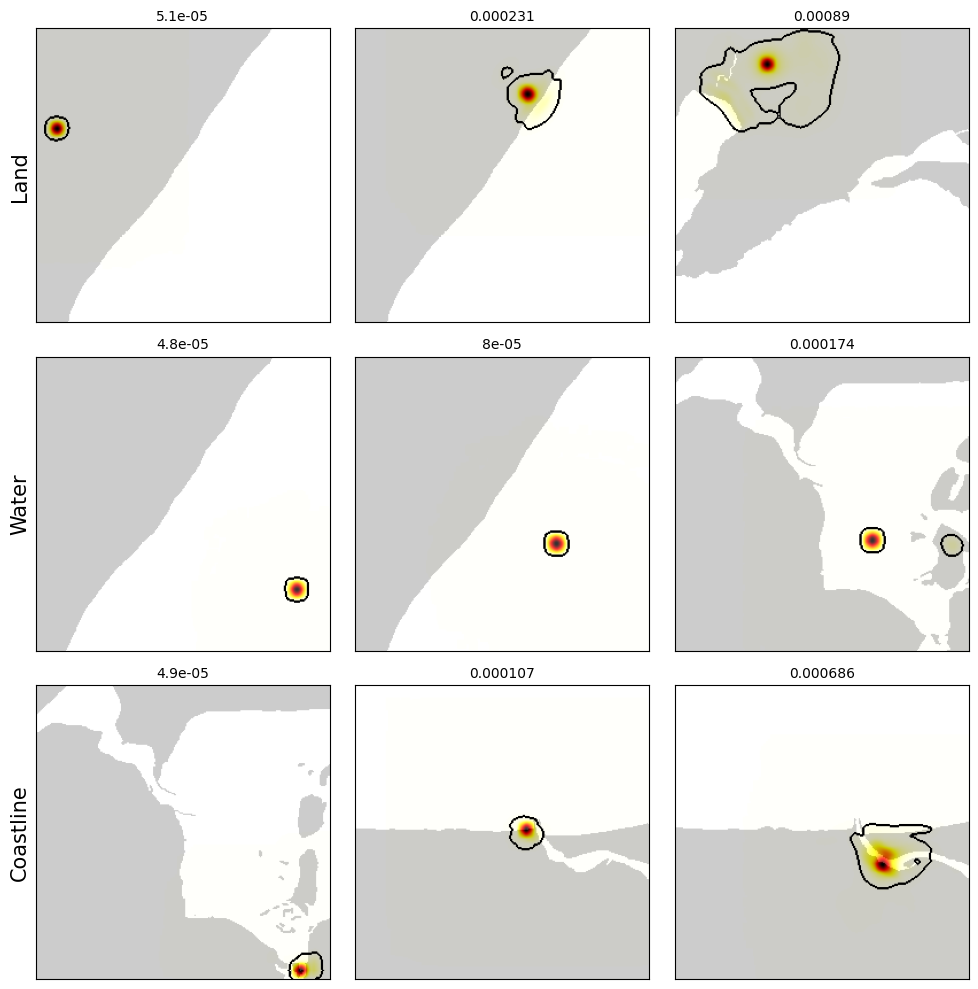

In [123]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

occlusion_type = 'zero'

for i, pixel_class in enumerate(['land','water','coastline']):
    p1,p5,p9 = get_example(pixel_class,occlusion_type,normalized=True,contrast=0.2)

    # Capitalize
    pixel_class = pixel_class.capitalize()
    ax[i,0].set_ylabel(pixel_class,size=15)

    for j, row in enumerate([p1,p5,p9]):

        pixel,weighted_context,heatmap,rgb,mask,edge = get_data_from_row(row,normalized=True,contrast=0.2)

        weighted_context = np.round(weighted_context,6)
        overlay = utils.occlusion_visualisation(mask, heatmap, alpha=0.8,edge_threshold=0.01)
        ax[i,j].imshow(overlay)
        ax[i,j].set_title(f'{weighted_context}',size=10)


ax = ax.flatten()
for a in ax:
    a.set_xticks([])
    a.set_yticks([])


utils.save_fig("weighted_context_examples_2")

411.3563320572182 9367.71177215449
[np.float64(411.3563320572182), np.float64(411.3563320572182), np.float64(591.3679806837304), np.float64(687.4033277452197), np.float64(723.3672406274272), np.float64(809.0109551449748), np.float64(867.9768990013782), np.float64(916.7544149346548), np.float64(1048.9790574029917), np.float64(1254.4380020153435), np.float64(2756.2838730324106), np.float64(9367.71177215449)]


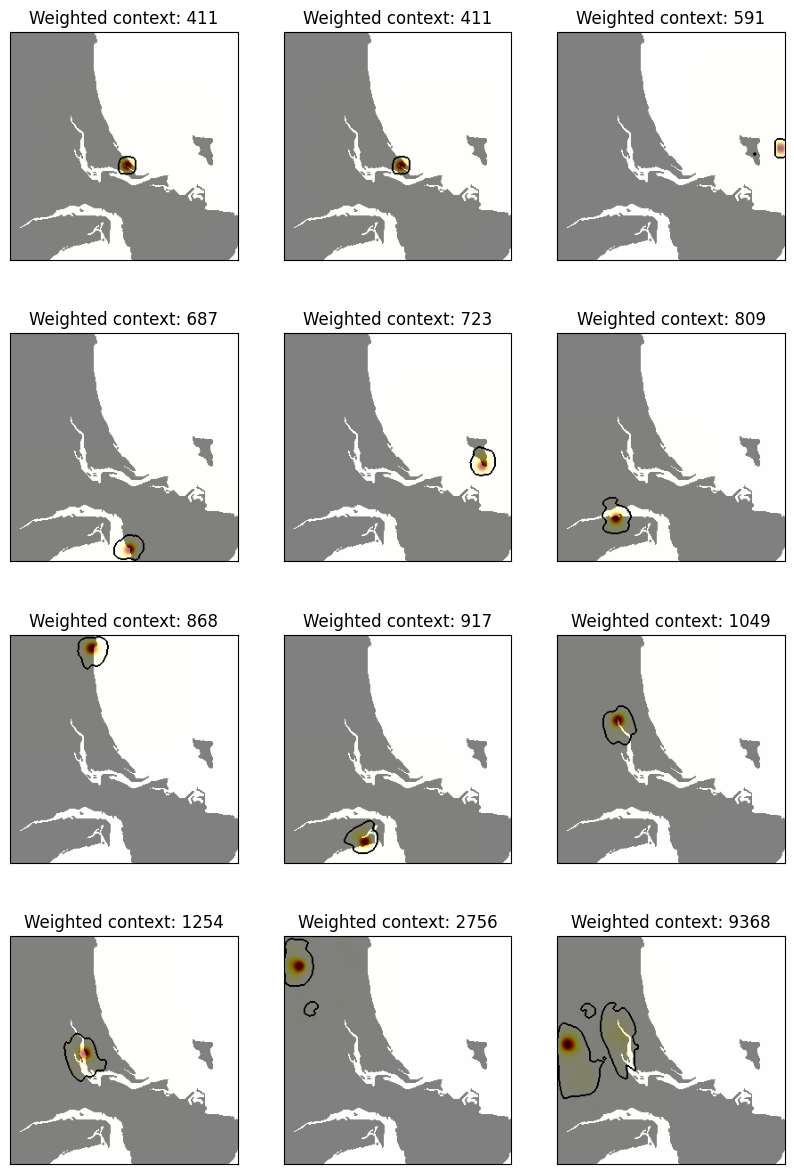

In [125]:
map_type = "pixel"
occlusion_type = "zero"
patch_size = 8
stride = 1

maps_df_selection = maps_df[ (maps_df['map_type'] == map_type)  
                            & (maps_df['occlusion_type'] == occlusion_type)
                            & (maps_df['patch_size'] == patch_size)
                            & (maps_df['stride'] == stride)]
name = "LC08_L2SP_205023_20170505_20200904_02_T1"
maps_df_selection = maps_df_selection[maps_df_selection['image_name'] == name]

weighted_context = maps_df_selection['weighted_context'].values
min_context = np.min(weighted_context)
max_context = np.max(weighted_context)
print(min_context, max_context)

# get deciles with max and min
deciles = np.percentile(weighted_context, np.arange(1, 100, 10), interpolation='nearest')
deciles = [min_context] + list(deciles) + [max_context]
print(deciles)

fig, ax = plt.subplots(4, 3, figsize=(10, 15))
ax = ax.flatten()

for i in range(len(deciles)):
    row = maps_df_selection[maps_df_selection['weighted_context'] == deciles[i]]
    
    pixel,weighted_context,heatmap,rgb,mask,edge = get_data_from_row(row)

    overlay = utils.occlusion_visualisation(mask, heatmap, alpha=0.5,edge_threshold=0.01)

    ax[i].imshow(overlay)
    ax[i].set_title(f'Weighted context: {weighted_context}')

    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Aggregations

In [21]:
map_type = "pixel"
patch_size = 8
stride = 1

wcs = []
occlusion_types = ['zero', 'mean', 'random']
for occlusion_type in occlusion_types:
    maps_df_selection = maps_df[ (maps_df['map_type'] == map_type)  
                                & (maps_df['occlusion_type'] == occlusion_type)
                                & (maps_df['patch_size'] == patch_size) 
                                & (maps_df['stride'] == stride)]

    water_wc = maps_df_selection[maps_df_selection['pixel_class'] == 'water']['normalized_weighted_context'].values
    land_wc = maps_df_selection[maps_df_selection['pixel_class'] == 'land']['normalized_weighted_context'].values
    coastline_wc = maps_df_selection[maps_df_selection['pixel_class'] == 'coastline']['normalized_weighted_context'].values

    wcs.append([water_wc, land_wc, coastline_wc])
pixel_types = ['Water', 'Land', 'Coastline']

for j in range(len(occlusion_types)):
    print(f'\n{occlusion_types[j]}:')
    for i in range(len(pixel_types)):
        min_wc = np.round(np.min(wcs[j][i]),6)
        max_wc = np.round(np.max(wcs[j][i]),6)
        mean_wc = np.round(np.mean(wcs[j][i]),6)
        median_wc = np.round(np.median(wcs[j][i]),6)

        print(pixel_types[i], min_wc, max_wc, mean_wc,median_wc)


zero:
Water 2.8e-05 0.001933 9.7e-05 8.2e-05
Land 2.8e-05 0.002506 0.000338 0.000243
Coastline 3e-05 0.001448 0.000159 0.000114

mean:
Water 2.8e-05 0.031222 0.002545 0.000693
Land 3e-05 0.016684 0.002525 0.001466
Coastline 3e-05 0.026787 0.001925 0.001065

random:
Water 3.8e-05 0.013102 0.000929 0.000294
Land 5.3e-05 0.0102 0.001214 0.000795
Coastline 3.6e-05 0.004926 0.000672 0.000499


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_86010/1922755561.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(wcs[0], labels=pixel_types)


Text(0, 0.5, 'Weighted Context')

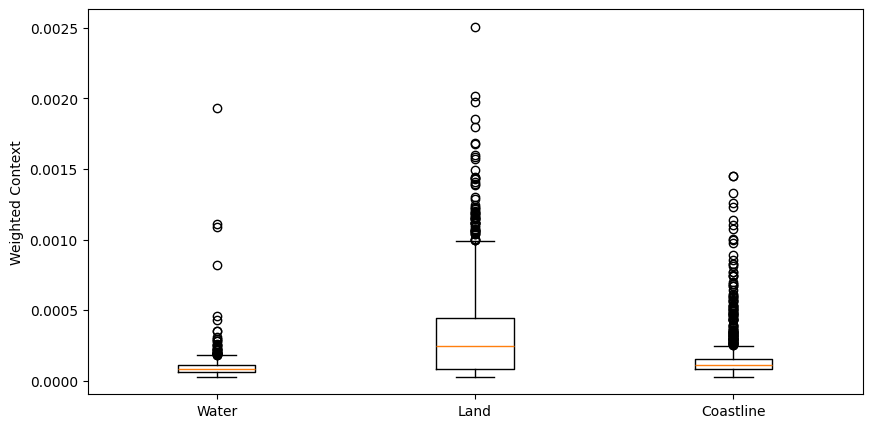

In [80]:
# Plot groups of boxplots for each occlusion type and pixel type
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(wcs[0], labels=pixel_types)
ax.set_ylabel('Weighted Context')

#utils.save_fig("weighted_context_boxplot")

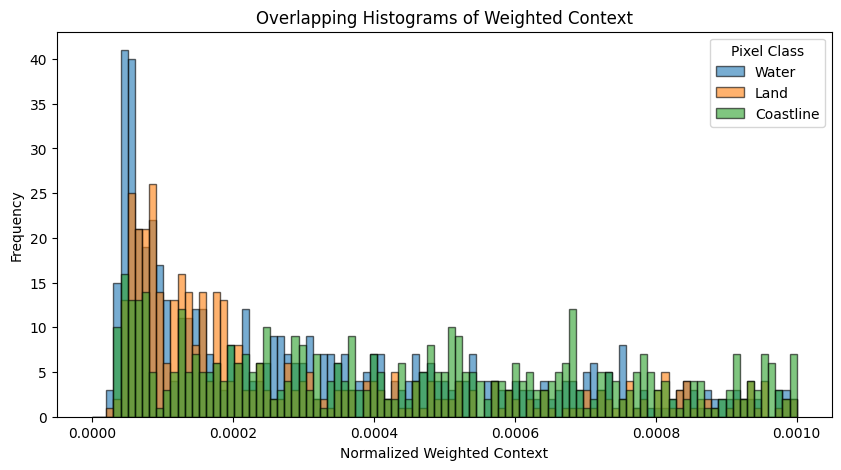

In [58]:
# Plot overlapping histograms
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, 0.001, 100)  # Define bins for consistent scaling

for wc, label in zip(wcs, pixel_types):
    ax.hist(wc, bins=bins, alpha=0.6, label=label, edgecolor='black')

# Customize the plot
ax.set_xlabel('Normalized Weighted Context')
ax.set_ylabel('Frequency')
ax.set_title('Overlapping Histograms of Weighted Context')
ax.legend(title='Pixel Class')

# Save the plot
#utils.save_fig("weighted_context_histogram")

# Show the plot
plt.show()

In [81]:
map_type = "pixel"
occlusion_type = "zero"
maps_df_selection = maps_df[ (maps_df['map_type'] == map_type) 
                            & (maps_df['occlusion_type'] == occlusion_type)]

p8_s1 = maps_df_selection[(maps_df_selection['patch_size'] == 8) & (maps_df_selection['stride'] == 1)]
p8_s4 = maps_df_selection[(maps_df_selection['patch_size'] == 8) & (maps_df_selection['stride'] == 4)]
p16_s8 = maps_df_selection[(maps_df_selection['patch_size'] == 16) & (maps_df_selection['stride'] == 8)]
p32_s16 = maps_df_selection[(maps_df_selection['patch_size'] == 32) & (maps_df_selection['stride'] == 16)]

rows = []
dfs = [p8_s1,p8_s4, p16_s8, p32_s16]
patch_sizes = [8, 8, 16, 32]
strides = [1, 4, 8, 16]
for i in range(len(patch_sizes)):
   
    df = dfs[i]

    water_wc = df[df['pixel_class'] == 'water']['normalized_weighted_context'].values
    land_wc = df[df['pixel_class'] == 'land']['normalized_weighted_context'].values
    coastline_wc = df[df['pixel_class'] == 'coastline']['normalized_weighted_context'].values

    pixel_types = ['water', 'land', 'coastline']
    wcs = [water_wc, land_wc, coastline_wc]

    median_water_wc = np.round(np.median(water_wc),6)
    median_land_wc = np.round(np.median(land_wc),6)
    median_coastline_wc = np.round(np.median(coastline_wc),6)

    rows.append([patch_sizes[i], strides[i],median_water_wc, median_land_wc, median_coastline_wc])

summary_df = pd.DataFrame(rows, columns=['Patch size','Stride', 'Water', 'Land', 'Coastline'])
summary_df

,Patch size,Stride,Water,Land,Coastline
0,8,1,0.000082,0.000243,0.000114
1,8,4,0.000083,0.000262,0.000117
2,16,8,0.000445,0.001237,0.000636
3,32,16,0.002893,0.006382,0.004067


In [22]:
map_type = "pixel"
maps_df_selection = maps_df[ (maps_df['map_type'] == map_type) 
                            & (maps_df['patch_size'] == 8) 
                            & (maps_df['stride'] == 1)]

ot_zero = maps_df_selection[maps_df_selection['occlusion_type'] == 'zero']
ot_mean = maps_df_selection[maps_df_selection['occlusion_type'] == 'mean']
ot_random = maps_df_selection[maps_df_selection['occlusion_type'] == 'random']

print(len(ot_zero), len(ot_mean), len(ot_random))

rows = []
dfs = [ot_zero, ot_mean, ot_random]
occlusion_types = ['zero', 'mean', 'random']
for i in range(len(occlusion_types)):
   
    df = dfs[i]

    water_wc = df[df['pixel_class'] == 'water']['normalized_weighted_context'].values
    land_wc = df[df['pixel_class'] == 'land']['normalized_weighted_context'].values
    coastline_wc = df[df['pixel_class'] == 'coastline']['normalized_weighted_context'].values

    pixel_types = ['water', 'land', 'coastline']
    wcs = [water_wc, land_wc, coastline_wc]

    n = len(water_wc) + len(land_wc) + len(coastline_wc)
    n = n/3 
    median_water_wc = np.round(np.median(water_wc),6)
    median_land_wc = np.round(np.median(land_wc),6)
    median_coastline_wc = np.round(np.median(coastline_wc),6)

    rows.append([occlusion_types[i], n,median_water_wc, median_land_wc, median_coastline_wc])

summary_df = pd.DataFrame(rows, columns=['Occlusion Value','n', 'Water', 'Land', 'Coastline'])
summary_df[['Occlusion Value', 'Water', 'Land', 'Coastline']]

4925 4925 4925


,Occlusion Value,Water,Land,Coastline
0,zero,0.000082,0.000243,0.000114
1,mean,0.000693,0.001466,0.001065
2,random,0.000294,0.000795,0.000499
